In [1]:
from qdhmc import HMC
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2022-08-18 19:39:09.112461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2022-08-18 19:39:09.112510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-18 19:39:12.391854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2022-08-18 19:39:12.391904: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 19:39:12.391934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HBHOF55J): /proc/driver/nvidia/ve

In [2]:
def guassian_log_prob(n, temp):
    def lp(x):
        return np.sum([-1 * x[i] for i in range(n)] + [-1 * x[i]**2 for i in range(n)])/temp
    return lp

def sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum([x[i]**2 for i in range(n)])/temp
    return lp

def double_well_log_prob(temp):
    def lp(x):
        return (-1*(x[0]**4 - 4 * x[0]**2 + x[1]**2) - 0.5 * x[0])/temp
    return lp

def rosenbrock(n, temp):
    def lp(x):
        return -1 * np.sum([10 * (x[i + 1] - x[i])**2 + (1 - x[i])**2 for i in range(n-1)])/temp
    return lp

def styblinski_tang(n, temp):
    def lp(x):
        return -1/2 * np.sum([x[i]**4 - 16 * x[i]**2 + 5 * x[i] for i in range(n)])/temp
    return lp

In [14]:
def run_exp(t, rep, precision, n, opt_len, temperature, log_prob, experiments):
    classical = []
    quantum = []

    test_c = HMC(log_prob, kernel_type='classical', num_vars=n, precision=precision, step_size=0.2)
    test_q = HMC(log_prob, kernel_type='quantum', precision=precision, r=rep, num_vars=n, t=t)
    
    for e in range(experiments):
        if e % 8 == 0:
            print(e)
        #init_state = tf.random.uniform(shape=[n], minval=-2**(precision - 2), maxval=2**(precision - 2))
        init_state = tf.random.uniform(shape=[n], minval=-tf.math.sqrt(2 * np.pi * 2 ** precision) / 4, \
                                        maxval=tf.math.sqrt(2 * np.pi * 2 ** precision) / 4)
        
        #init_state = tf.convert_to_tensor([2.0 for _ in range(n)])
        init = log_prob(init_state)

        s, m, std, a, rs = test_c.run_hmc(opt_len, 0, init_state=init_state)
        s_q, m_q, std_q, a_q, rs_q = test_q.run_hmc(opt_len, 0, init_state=init_state)

        classical.append(rs.target_log_prob.numpy().tolist())
        classical[-1].insert(0, init)
        quantum.append(rs_q.target_log_prob.numpy().tolist())
        quantum[-1].insert(0, init)
        
    return classical, quantum

In [15]:
def plot_exp(c, q):
    cs_mean = np.mean(c, axis=0)
    qs_mean = np.mean(q, axis=0)

    x = [i for i in range(len(cs_mean))]

    cs_ci = 1.96 * np.std(c, axis=0)/np.sqrt(100)
    qs_ci = 1.96 * np.std(q, axis=0)/np.sqrt(100)

    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(cs_mean, label='Classical')
    ax.plot(qs_mean, label='Quantum')

    ax.fill_between(x, (cs_mean - cs_ci), (cs_mean + cs_ci), color='b', alpha=.1)
    ax.fill_between(x, (qs_mean - qs_ci), (qs_mean + qs_ci), color='orange', alpha=.1)

    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

In [16]:
def plot_sub_fig(c, q, ax):
    cs_mean = np.mean(c, axis=0)
    qs_mean = np.mean(q, axis=0)

    x = [i for i in range(len(cs_mean))]

    cs_ci = 1.96 * np.std(c, axis=0)/np.sqrt(100)
    qs_ci = 1.96 * np.std(q, axis=0)/np.sqrt(100)

    ax.plot(cs_mean, label='Classical')
    ax.plot(qs_mean, label='Quantum')

    ax.fill_between(x, (cs_mean - cs_ci), (cs_mean + cs_ci), color='b', alpha=.1)
    ax.fill_between(x, (qs_mean - qs_ci), (qs_mean + qs_ci), color='orange', alpha=.1)

    #plt.xlabel("Iteration")
    #plt.ylabel("Energy")

In [33]:
# HYPERPARAMETERS
experiments = 50
opt_len = 50
trotter_time = 2.0
trotter_steps = 3
precision = 4

In [34]:
num_variables = 2
temp = 1.0
log_prob = guassian_log_prob(num_variables, temp)

classical_guas, quantum_guas = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


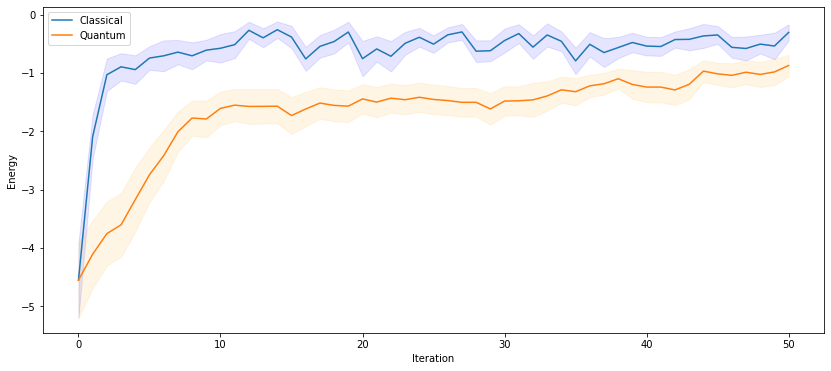

In [35]:
plot_exp(classical_guas, quantum_guas)

In [36]:
num_variables = 2
temp = 0.1

log_prob = guassian_log_prob(num_variables, temp)

classical_guas_t, quantum_guas_t = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


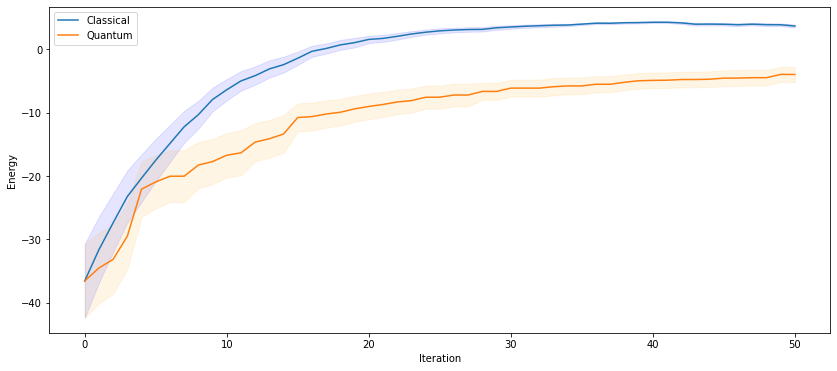

In [37]:
plot_exp(classical_guas_t, quantum_guas_t)

In [38]:
num_variables = 3
temp = 1.0
log_prob = rosenbrock(num_variables, temp)

classical_ros, quantum_ros = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


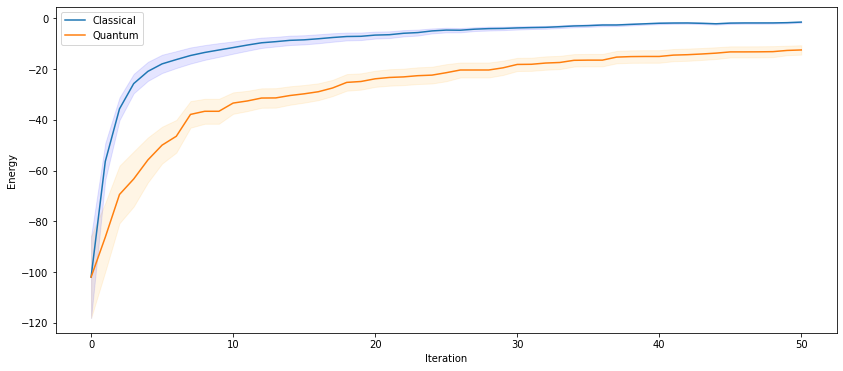

In [39]:
plot_exp(classical_ros, quantum_ros)

In [40]:
num_variables = 3
temp = 0.1
log_prob = rosenbrock(num_variables, temp)

classical_ros_t, quantum_ros_t = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


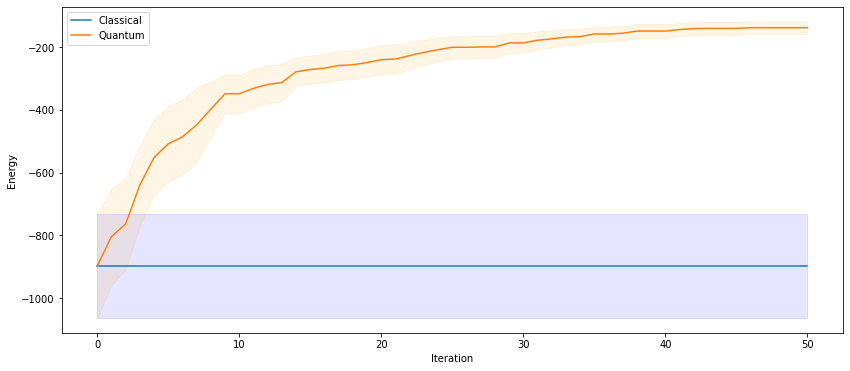

In [41]:
plot_exp(classical_ros_t, quantum_ros_t)

In [42]:
num_variables = 2
temp = 1.0
log_prob = double_well_log_prob(temp)

classical_dw, quantum_dw = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


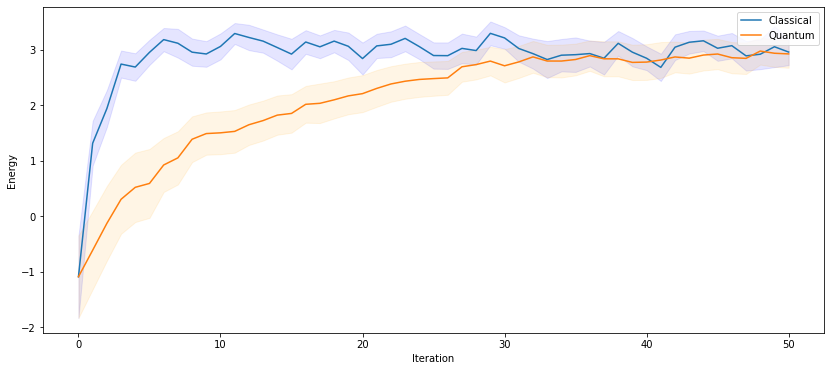

In [43]:
plot_exp(classical_dw, quantum_dw)

In [44]:
num_variables = 2
temp = 0.1
log_prob = double_well_log_prob(temp)

classical_dw_t, quantum_dw_t = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


In [45]:
num_variables = 3
temp = 1.0
log_prob = styblinski_tang(num_variables, temp)

classical_st, quantum_st = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


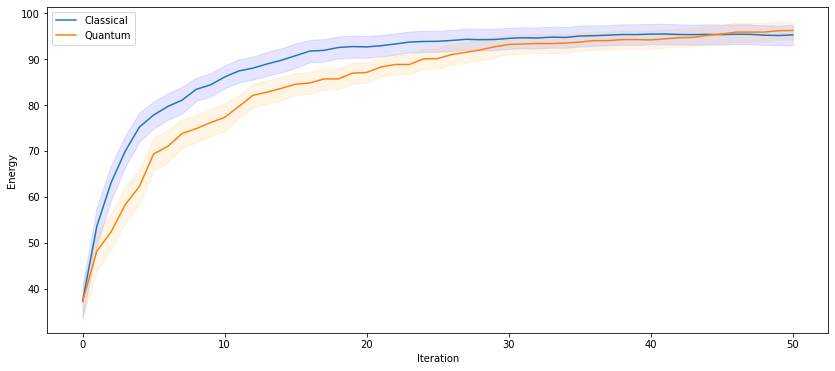

In [46]:
plot_exp(classical_st, quantum_st)

In [47]:
num_variables = 3
temp = 0.1
log_prob = styblinski_tang(num_variables, temp)

classical_st_t, quantum_st_t = run_exp(trotter_time, trotter_steps, precision, num_variables, opt_len, temp, log_prob, experiments)

0
8
16
24
32
40
48


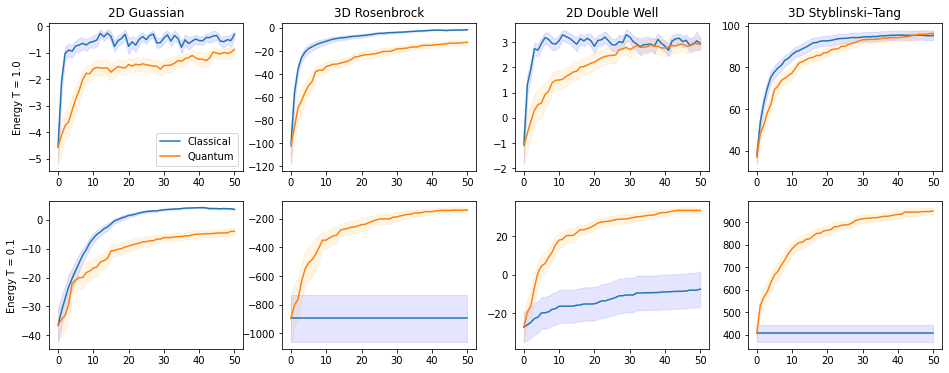

In [50]:
fig, axs = plt.subplots(2, 4, figsize=(16, 6))

plot_sub_fig(classical_guas, quantum_guas, axs[0, 0])
plot_sub_fig(classical_guas_t, quantum_guas_t, axs[1, 0])

plot_sub_fig(classical_ros, quantum_ros, axs[0, 1])
plot_sub_fig(classical_ros_t, quantum_ros_t, axs[1, 1])

plot_sub_fig(classical_dw, quantum_dw, axs[0, 2])
plot_sub_fig(classical_dw_t, quantum_dw_t, axs[1, 2])

plot_sub_fig(classical_st, quantum_st, axs[0, 3])
plot_sub_fig(classical_st_t, quantum_st_t, axs[1, 3])

axs[0, 0].legend()
axs[0, 0].set_ylabel("Energy T = 1.0")
axs[1, 0].set_ylabel("Energy T = 0.1")
axs[0, 0].set_title('2D Guassian')
axs[0, 1].set_title('3D Rosenbrock')
axs[0, 2].set_title('2D Double Well')
axs[0, 3].set_title('3D Styblinski–Tang')

plt.show()